In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
data = data.drop('id', axis = 1)

In [3]:
# global constants
N_ESTIMATORS = 22
TARGET = 'SeriousDlqin2yrs'
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

In [4]:
# split in train, validation set
data = data.sample(frac = 1)

N_REC = data.shape[0]

N_TRAIN = int(N_REC * 0.8)
N_VALID = N_REC - N_TRAIN

train_df = data[:N_TRAIN]
valid_df = data[N_TRAIN:]

In [5]:
# estrae X: matrice features ed y, labels
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values
y_train = train_df[TARGET].values

xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values
y_valid = valid_df[TARGET].values

### Train the XGBoost Classifier

In [6]:
# 22 for early stopping, to avoid overfitting to the train set

param_dist = {'objective':'binary:logistic', 'n_estimators':N_ESTIMATORS}

clf = xgb.XGBClassifier(use_label_encoder=False, **param_dist)

# valuto su train e su validation set
clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        eval_metric='auc', verbose=True)

evals_result = clf.evals_result()

[0]	validation_0-auc:0.84977	validation_1-auc:0.85122
[1]	validation_0-auc:0.85289	validation_1-auc:0.85416
[2]	validation_0-auc:0.85651	validation_1-auc:0.85661
[3]	validation_0-auc:0.85712	validation_1-auc:0.85653
[4]	validation_0-auc:0.85811	validation_1-auc:0.85725
[5]	validation_0-auc:0.85872	validation_1-auc:0.85780
[6]	validation_0-auc:0.86041	validation_1-auc:0.85885
[7]	validation_0-auc:0.86325	validation_1-auc:0.86131
[8]	validation_0-auc:0.86543	validation_1-auc:0.86211
[9]	validation_0-auc:0.86679	validation_1-auc:0.86352
[10]	validation_0-auc:0.86848	validation_1-auc:0.86447
[11]	validation_0-auc:0.87029	validation_1-auc:0.86499
[12]	validation_0-auc:0.87137	validation_1-auc:0.86497
[13]	validation_0-auc:0.87342	validation_1-auc:0.86472
[14]	validation_0-auc:0.87418	validation_1-auc:0.86553
[15]	validation_0-auc:0.87573	validation_1-auc:0.86574
[16]	validation_0-auc:0.87721	validation_1-auc:0.86625
[17]	validation_0-auc:0.87857	validation_1-auc:0.86641
[18]	validation_0-au

In [7]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

In [8]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

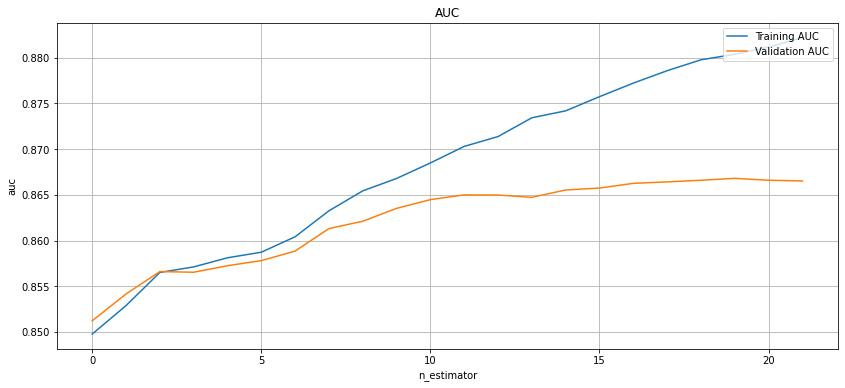

In [9]:
plot_auc(train_hist, val_hist)

In [10]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.71%


### Prediction on the TEST set (for submisson to Kaggle)

In [11]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# devo imputare i missing values
# le statistiche per l'inputation le prendo dal train set
orig_data = pd.read_csv('cs-training.csv')
df_stats = orig_data.describe().transpose()
mean_mi = df_stats.loc[COL1_MISSING, 'mean']
mean_nod = df_stats.loc[COL2_MISSING, 'mean']

# inpute missing values, add the two indicator columns
condition = (orig_test[COL1_MISSING].isna())

orig_test['isna_mi'] = 0
orig_test.loc[condition, 'isna_mi'] = 1
orig_test.loc[condition, COL1_MISSING] = mean_mi

condition = (orig_test[COL2_MISSING].isna())

orig_test['isna_nod'] = 0

orig_test.loc[condition, 'isna_nod'] = 1
orig_test.loc[condition, COL2_MISSING] = mean_nod

In [12]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [13]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test)

y_pred = y_pred[:, 1]

In [14]:
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission12.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')